In [3]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# <Step1. 크롤링> : 크롤링으로 웹 데이터 가져오기

In [4]:
from selenium import webdriver
from bs4 import BeautifulSoup
import re

# 윈도우용 크롬 웹드라이버 실행 경로
# 크롬 드라이버를 다운 받고 그 위치를 적는다.
# 파일과 같은 위치로 옮겼기 때문에 아래의 주소를 적는다.
excutable_path = "./chromedriver.exe"

source_url = "https://namu.wiki/RecentChanges"

# 사이트의 html 구조에 기반하여 크롤링을 수행
driver = webdriver.Chrome(executable_path=excutable_path)
driver.get(source_url)

In [5]:
# 컨텐츠가 모두 로딩되기 전에 아래 코드들을 실행하면
# 제대로 된 결과가 나오지 않는다
# 따라서 페이지 로딩이 끝난 후 아래 코드들을 실행한다.
req = driver.page_source
soup = BeautifulSoup(req, "html.parser")
contents_table = soup.find(name="table")
table_body = contents_table.find(name='tbody')
table_rows = table_body.find_all(name='tr')

In [6]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성
page_url_base = "https://namu.wiki"
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all("td")[0]
    td_url = first_td.find_all("a")
    if len(td_url) > 0:
        page_url = page_url_base + td_url[0].get("href")
        if "png" not in page_url:
            page_urls.append(page_url)

# 중복 url 제거
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)
    
# 크롤링에 사용한 브라우저 종료
driver.close()

https://namu.wiki/w/%ED%85%8C%EB%9D%BC%EC%8B%9C%EB%A7%88%20%ED%83%80%EC%BF%A0%EB%A7%88
https://namu.wiki/w/%EC%84%9C%EC%9A%B0
https://namu.wiki/w/%EB%A1%9C%EC%A0%80%20%EC%BD%94%EB%A8%BC
https://namu.wiki/w/%ED%8E%98%EC%9D%B4%EB%AA%AC
https://namu.wiki/w/%ED%86%A0%ED%83%88%20%EC%9B%8C:%20%EC%9B%8C%ED%95%B4%EB%A8%B8%203/%EC%BD%94%EB%A5%B8


### [나무위키 최근변경 데이터 크롤링]

In [7]:
# 크롤링한 데이터를 데이터프레임으로 만들기위해 준비
colums = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=colums)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터프레임으로 만듦
for page_url in page_urls:
    
    # 사이트의 html 구조에 기반하여 크롤링을 수행
    driver = webdriver.Chrome(executable_path=excutable_path)
    driver.get(page_url)
    req = driver.page_source
    soup = BeautifulSoup(req, "html.parser")
    contents_table = soup.find(name='article')
    title = contents_table.find_all('h1')[0]
    
    # 카테고리 정보가 없는 경우 확인
    if len(contents_table.find_all('h1')) > 0:
        category = contents_table.find_all('ul')[0]
    else:
        category = None
        
    content_paragraphs = contents_table.find_all(name='div', attrs={'class':'wiki-paragraph'})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우, 빈 문자열로 대체
    if title is not None:
        row_title = title.text.replace('\n', ' ')
    else:
        row_title = ""
        
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우, 빈 문자열로 대체
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace('\n', ' '))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.appen("")
        
    # 페이지 내 카테고리 정보에서 "분류"라는 단어와 개행 문자를 제거한 뒤 추출
    # 만약 없는 경우, 빈 문자열로 대체
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
        
    # 모든 정보를 하나의 데이터 프레임에 저장
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)
    
    # 크롤링에 사용한 브라우저 종료
    driver.close()

In [8]:
df.head(5)

,title,category,content_text
0,테라시마 타쿠마,일본 남성 성우/ㅌ일본 남가수/ㅌ1983년 출생2004년 데뷔이시카와현 출신 인물누명,테라시마 타쿠마寺島 拓篤 ｜ Takuma Terashima이름테라시마 타쿠마(寺(て...
1,서우,한국 여배우/ㅅ1985년 출생2007년 데뷔서울특별시 출신 인물선화예술고등학교 출신...,서우瑞雨 | Seo Woo본명 김문주출생 1985년[1] 7월 7일 (36세)서울특...
2,로저 코먼,미국 영화 감독1926년 출생미시간 주 출신 인물,역대 아카데미 시상식 공로상제82회 (2010년)로저 코먼2016년 모습.Ro...
3,페이몬,원신/등장인물원신/밈,은(는) 여기로 연결됩니다. 솔로몬의 72악마에 대한 내용은 파이몬 문서를의 ...
4,토탈 워: 워해머 3/코른,토탈 워: 워해머,상위 문서: 토탈 워: 워해머 3토탈 워: 워해머 시리즈의 등장 세력1부기본판...


# <Step2. 추출> : 키워드 추출

### [텍스트 데이터 전처리]

In [9]:
# 텍스트 정제 함수 : 한글 이외의 문자는 전부 제거
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]+')  # 한글의 정규 표현식
    result = hangul.sub('', text)
    return result

In [10]:
print(text_cleaning(df['content_text'][0]))

테라시마 타쿠마    이름테라시마 타쿠마   직업성우 가수출생년 월 일 세일본 이시카와현국적 일본신체형가족양친 형 남동생배우자 사토 사토미년 결혼현재소속사프로덕션 바오밥액셀원현재레이블란티스활동 시기성우  년  현재가수  년  현재별명 타쿰 테라시 오타쿠마링크 공식 프로필  아티스트 프로필   블로그 개요 하트 커넥트 성우 낚시 사건 오타쿠마 아이돌 마스터 시리즈에서 음악활동 이야깃거리 주요 출연작 애니메이션 게임 특촬 드라마  관련 문서 일본 남성 성우 남 중 둘째로 형과 남동생이 하나씩 있다여성향 노멀 게임 출연이 많아서 여성 팬들이 많다 기본적으로 목소리는 약간 장난스러운 느낌이지만 낮게 까는 목소리도 일품이며 기합성에도 일가견이 있다술자리에서 안녕 절망선생 시리즈의 오프닝을 작사작곡한 에게 너 정말 아쿠에리온에 나오는 아폴로 맞냐고 의심당한 적이 있다 참고로 는 파칭코로 아쿠에리온을 알고 있을 뿐 아쿠에리온의 애니메이션은 본 적이 없고 아폴로가 하는 대사 같은 것도 모르므로 아무리 해봐야 네가 아폴로 성우라니그럴 리가 없어라고 반박당하는 이상한 전개가 무한반복되었다고 한다카미야 히로시가 안녕 절망방송에서 타쿠마을 만들어 열창했다 알만한 사람은 다 아는 가메라 노래를 테라시마 타쿠마 테라시마 타쿠마로 바꿔 불렀다 신타니 료코와 본인은 이해하기 어려웠지만 녹음 현장은 아재들의 웃음바다로 변했다년 하트 커넥트 성우 낚시 사건에 연루되어 동료 성우 이치키 미츠히로를 이지메하고 웃음거리로 만들었다는 루머에 시달렸다 당시 몰래카메라를 당한 이치키에 대해 사람이 무너지는 순간이 아름답다고 생각했습니다웃음라고 발언을 하며 이지메범이라는 낙인이 찍혀버렸다 월 일에 올라온 본인 사과문에서도 이치키와 친한 사이이며 단순한 농담성 발언이었음에도 오해를 사고 있다고 말했지만 이 사건을 이지메 범죄로 단정 지은 사람들에 의해 파렴치한 적반하장 발언으로 해석되며 이미지가 더욱 나락으로 떨어졌다그러나 이 사건을 재조명한 항목을 참조해 보면 알 수 있듯 이 사건은 조작된 점이 많은 해

In [11]:
# 각 피처마다 데이터 전처리를 적용
df['title'] = df['title'].apply(lambda x: text_cleaning(x))
df['category'] = df['category'].apply(lambda x: text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x: text_cleaning(x))
df.head(5)

,title,category,content_text
0,테라시마 타쿠마,일본 남성 성우ㅌ일본 남가수ㅌ년 출생년 데뷔이시카와현 출신 인물누명,테라시마 타쿠마 이름테라시마 타쿠마 직업성우 가수출생년 월 일 세일본 이시...
1,서우,한국 여배우ㅅ년 출생년 데뷔서울특별시 출신 인물선화예술고등학교 출신수원과학대학교 출...,서우 본명 김문주출생 년 월 일 세서울특별시신체 프로필 상 형가족 어머니 녀...
2,로저 코먼,미국 영화 감독년 출생미시간 주 출신 인물,역대 아카데미 시상식 공로상제회 년로저 코먼년 모습 로저 윌리엄 코먼 개...
3,페이몬,원신등장인물원신밈,은는 여기로 연결됩니다 솔로몬의 악마에 대한 내용은 파이몬 문서를의 번 문단을의...
4,토탈 워 워해머 코른,토탈 워 워해머,상위 문서 토탈 워 워해머 토탈 워 워해머 시리즈의 등장 세력부기본판제국드워프그...


### [말뭉치 만들기]

In [26]:
# 각 피처마다 말뭉치를 생성
title_corpus = "".join(df['title'].tolist())
category_corpus = "".join(df['category'].tolist())
content_corpus = "".join(df['content_text'].tolist())
print(title_corpus)

테라시마 타쿠마 서우 로저 코먼 페이몬 토탈 워 워해머 코른 판테라밴드 파일바라쿠다 년 지구멸망설 긁지 않은 복권   등장인물 조현수프로게이머   바라쿠다  디나모 브랸스크 워마드 성체 훼손 사건 주성치 파일 브리즈번 올림픽 로고   포르마조 호리우치 켄유 분류 사투른 라멘스코예 아바타영화 년 한국시리즈경기 내용 파이크리그 오브 레전드 설운도 손흥민토트넘 홋스퍼  젤다의 전설 스카이워드 소드보스 콘스콘 토미타 미유 프린스클래시 로얄 서든어택캐릭터 호소야 요시마사 분류 즈나먀 노긴스크 마인크래프트몹중립적 신구데블스 기술교육과 분류 스트로기노 모스크바 스파이럴영화 좀비묵시록 시리즈 김성근  노희지 마침표   서울 버스  파일서해금빛열차 로고 광명 버스  전북일보 분류 로디나 모스크바 리그 오브 레전드  브리즈번 올림픽 성일 우리미 의 검 김정일 우호우주인 판타스 성인   유키히사 겐조 시라키    이동 수단스포츠카  도쿄 올림픽 안양과천 분류 체르타노보 모스크바 공격전이다 타카나시 켄고 꼬마마법사 레미아이템 젤다의 전설 스카이워드 소드등장인물  디나모 블라디보스토크 스즈키 이루마작중 행적 태너 로아크 폭룡 조미니 히노 듀트로 하시모토 신지애니메이터 카를로스 보카네그라 타카기 와타루  엔터테인먼트 부문작품 목록 몰라인피니트 지민 알타입 분류 디나모 브랸스크 카이네 라면 트리 오브 세이비어등장인물마스터 분류 즈나먀 트루다 오레호보주예보  도쿄 올림픽개막식 하야시 유이치로 토르마블 시네마틱 유니버스작중 행적페이즈  


### [konply를 이용한 키워드 추출]

In [ ]:
# konlpy 사용하기가 되게 힘들다
# java path 설정
# Jpype1 version 0.7.0 사용
# konlpy version 0.5.1 사용
# https://m.blog.naver.com/kiddwannabe/221795961189

In [13]:
from konlpy.tag import Okt
from collections import Counter

# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [14]:
count

Counter({'테라': 67,
         '시마': 34,
         '타쿠마': 10,
         '이름': 281,
         '직업': 24,
         '성우': 194,
         '가수': 55,
         '출생': 20,
         '년': 1716,
         '월': 1169,
         '일': 814,
         '일본': 486,
         '이시카와현': 1,
         '국적': 15,
         '신체형': 3,
         '가족': 47,
         '양친': 2,
         '형': 47,
         '남동생': 13,
         '배우자': 6,
         '사토': 21,
         '사토미': 6,
         '결혼': 27,
         '현재': 212,
         '소속사': 18,
         '프로덕션': 11,
         '바오밥': 2,
         '액셀': 4,
         '레이블': 62,
         '란티스': 1,
         '활동': 169,
         '시기': 65,
         '별명': 80,
         '타쿰': 1,
         '시': 288,
         '오타쿠': 10,
         '마': 137,
         '링크': 112,
         '공식': 117,
         '프로필': 20,
         '아티스트': 12,
         '블로그': 17,
         '개요': 63,
         '하트': 39,
         '커넥트': 7,
         '낚시': 9,
         '사건': 334,
         '아이돌': 77,
         '마스터': 315,
         '시리즈': 244,
         '음악': 150,
       

### [키워드 가다듬기]

In [15]:
# 한글자 키워드 제거
remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
print(remove_char_counter)

Counter({'문단': 1687, '문서': 1581, '이전': 1458, '역사': 1384, '때문': 757, '한국': 688, '라면': 629, '배급': 535, '올림픽': 534, '이후': 520, '정도': 518, '리그': 509, '사람': 506, '시즌': 499, '자신': 494, '일본': 486, '부분': 483, '경우': 470, '차량': 454, '다른': 434, '공격': 431, '파이크': 428, '토론': 422, '감독': 421, '게임': 418, '합의': 416, '사항': 414, '대한': 403, '내용': 397, '영화': 393, '모습': 356, '사용': 350, '미국': 339, '사건': 334, '마스터': 315, '생각': 307, '김성근': 307, '선수': 304, '본인': 301, '사실': 300, '또한': 299, '시작': 298, '주성치': 296, '경기': 292, '선발': 291, '매우': 283, '이름': 281, '캐릭터': 278, '제공': 278, '하나': 277, '위해': 270, '방송': 263, '속도': 261, '문제': 258, '가장': 256, '다시': 255, '등장': 252, '최고': 250, '상황': 246, '시리즈': 244, '기록': 242, '관련': 235, '당시': 235, '성체': 234, '토르': 231, '프리미어': 228, '밴드': 225, '시간': 223, '대해': 218, '야구': 218, '도쿄': 214, '현재': 212, '수입': 207, '능력': 203, '이루마': 201, '마법': 200, '추가': 199, '성우': 194, '처음': 193, '모두': 191, '플레이': 190, '실제': 188, '역시': 188, '이야기': 188, '논란': 188, '가격': 188, '도움': 184, '자체': 183, '멤버': 1

In [16]:
# 불용어 제거
# 한국어 약식 불용어사전 예시 파일
korean_stopwords_path = "./data/korean_stopwords.txt"

# 텍스트 파일 오픈
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [17]:
# 나무위키 페이지에 맞는 불용어를 추가
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

In [18]:
# 키워드 데이터에서 불용어를 제거
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'문단': 1687, '이전': 1458, '역사': 1384, '한국': 688, '라면': 629, '배급': 535, '올림픽': 534, '리그': 509, '사람': 506, '시즌': 499, '일본': 486, '부분': 483, '차량': 454, '공격': 431, '파이크': 428, '토론': 422, '감독': 421, '게임': 418, '합의': 416, '사항': 414, '대한': 403, '영화': 393, '미국': 339, '사건': 334, '마스터': 315, '김성근': 307, '선수': 304, '본인': 301, '시작': 298, '주성치': 296, '경기': 292, '선발': 291, '캐릭터': 278, '제공': 278, '위해': 270, '방송': 263, '속도': 261, '문제': 258, '다시': 255, '등장': 252, '최고': 250, '시리즈': 244, '기록': 242, '관련': 235, '당시': 235, '성체': 234, '토르': 231, '프리미어': 228, '밴드': 225, '대해': 218, '야구': 218, '도쿄': 214, '현재': 212, '수입': 207, '능력': 203, '이루마': 201, '마법': 200, '성우': 194, '처음': 193, '플레이': 190, '실제': 188, '역시': 188, '이야기': 188, '논란': 188, '가격': 188, '도움': 184, '자체': 183, '멤버': 182, '다년': 177, '시절': 177, '상태': 174, '참고': 172, '활동': 169, '대회': 168, '출연': 167, '가지': 167, '체력': 167, '버전': 165, '일부': 162, '존재': 162, '여성': 160, '성능': 160, '라인': 159, '언급': 158, '전체': 158, '편이': 158, '이유': 158, '접기': 158, '워마드': 1

# <Step3. 시각화> : 워드 클라우드 시각화

In [19]:
import random
import pytagcloud
import webbrowser

In [20]:
# 가장 출현 빈도수가 높은 40개의 단어를 선정
ranked_tags = remove_char_counter.most_common(40)

# pytagcloud로 출력할 40개의 단어를 입력. 단어 출력의 최대 크기는 80으로 제한
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

# pytagcloud 이미지를 생성. 폰트는 나눔 고딕을 사용
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

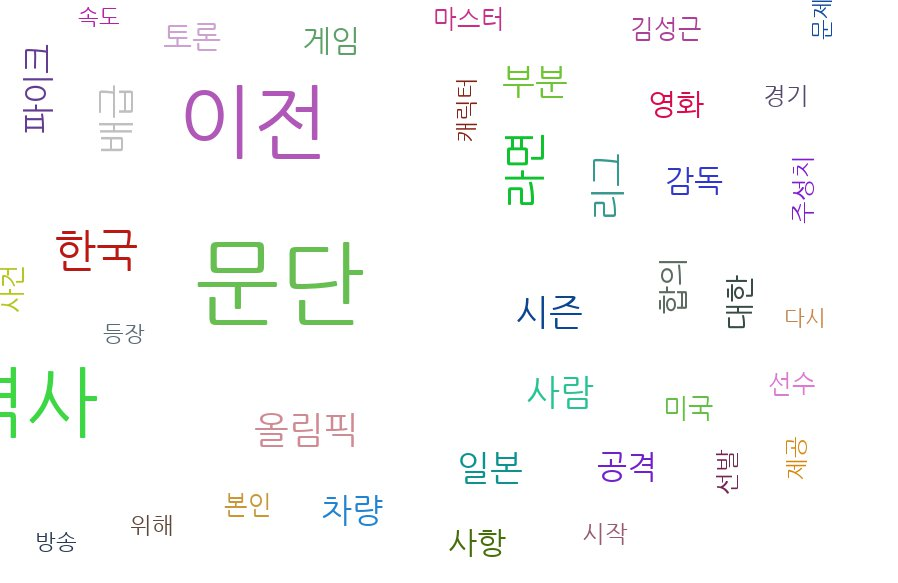

In [21]:
# 생성한 이미지를 주피터 노트북상에서 출력
from IPython.display import Image
Image(filename='wordcloud.jpg')

### [나무위키 키워드 시각화]

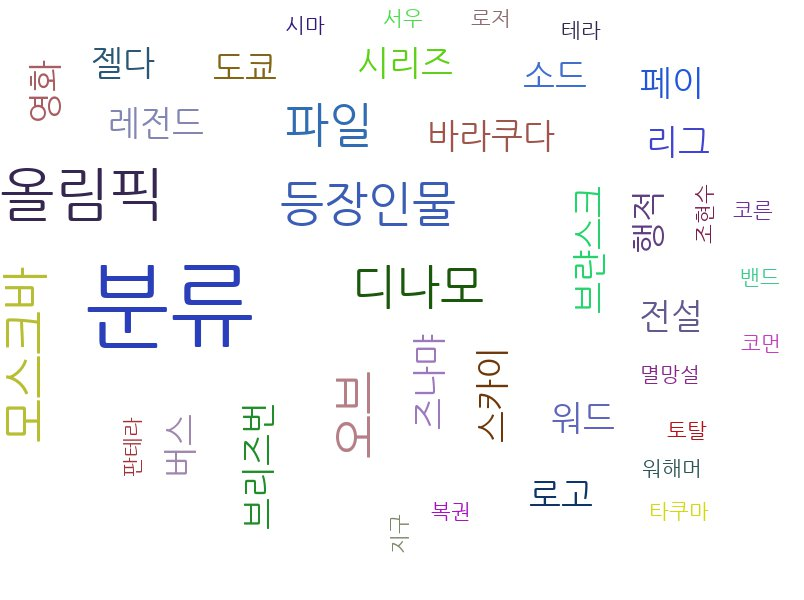

In [24]:
# 제목 키워드
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

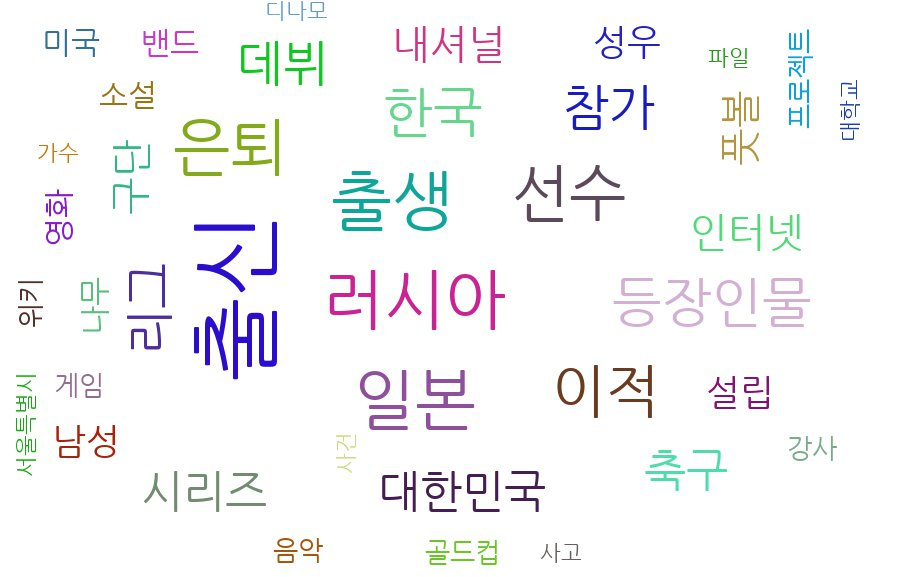

In [27]:
# 카테고리 키워드
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')